In [75]:
import numpy as np
from numpy import *
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import cm

import cv2

   

%matplotlib inline



def draw(pointList, makeVideo=False):
       
    
    fig, ax = plt.subplots()

    plt.ylim(0.0, 100.0)
    plt.xlim(0.0, 100.0)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.grid(linestyle='--')


    #--------------------draw pockets--------------------    
    alphaValue = 0.4
    for pt in corners:
        ax.add_artist(plt.Circle(pt, epsilon1, color='orange', alpha=alphaValue))
        #make the fallPocket red
    ax.add_artist(plt.Circle((sideLen/2, sideLen/2), epsilon2, color='orange', alpha=alphaValue))
    
    #make the fallPocket red
    if fallPocket==(sideLen/2, sideLen/2):
        ax.add_artist(plt.Circle(fallPocket, epsilon2, color='red', alpha=alphaValue))
    else:
        ax.add_artist(plt.Circle(fallPocket, epsilon1, color='red', alpha=alphaValue))
    #--------------------draw trajectory---------------
    xList = []
    yList = []
    for pt in pointList:
        xList.append(pt[0])
        yList.append(pt[1])
    
    colors = cm.rainbow(np.linspace(0, 1, len(xList)))
    
    images=[]
    for i in range(len(xList)-1):
        plt.plot(xList[i:i+2], yList[i:i+2], color=colors[i], marker='o')
        imgName = 'images/' + str(i) + '.png'
        plt.savefig(imgName)
        images.append(cv2.imread(imgName))
    
    plt.title("Trajectroy: p0=" + str(pointList[0]) + ", p1=" + str(pointList[1]))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    
    
    print("len(images) =", len(images))
    
    
    #--------------------now make video---------------
    if makeVideo:
        
        height,width,layers=images[1].shape
        video=cv2.VideoWriter('billiard.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 5, (width,height))

        for j in range(len(images)):
            video.write(images[j])

        cv2.destroyAllWindows()
        video.release()

        print("Video Done!")

    
    
    
   
  

In [76]:
#sides = 0, 1, 2, 3 (bottom, right, top, left)
sideLen = 100
corners = [(0,0), (sideLen, 0), (sideLen, sideLen), (0, sideLen)]

#given a side s, return its endpoints (x1 ,y1, x2, y2)

sideCoords = []
sideCoords.append([0,0, sideLen, 0])#bottom side
sideCoords.append([sideLen,0, sideLen, sideLen])#right side
sideCoords.append([sideLen,sideLen, 0, sideLen])#top side
sideCoords.append([0,sideLen, 0, 0])#left side

    

In [77]:
def getSide(pt):
    x,y = pt
    if x==0:
        return 3
    if x==sideLen:
        return 1
    if y==0:
        return 0
    if y==sideLen:
        return 2

In [78]:
# input: point_i (pi), point_i+1 (pil), line_i (li), side_i (si)
# output: point_i+1 (piNew), point_i+2 (piNextNew), line_i+1 (liNew), side_i (siNew)

#siNext is the side of piNext

def getNextPoint(pi, piNext):

    temp = [sideLen, sideLen, 0, 0]
    siNext = getSide(piNext)
#     -------------------------------------------------------------------------------
    if siNext%2==1: #1, or 3
            
        newy = 0
        if piNext[1] > pi[1]:
            newy = sideLen # axis = horizontal,    expect newy=sideLen or 0
#         print("expect newy = ", newy)
        
        
        if siNext==1:
            newx = piNext[0] -  abs( (piNext[0]-pi[0]) * (newy-piNext[1]) / (piNext[1]-pi[1]) )
        else:#siNext==3
            newx = piNext[0]  +  abs( (piNext[0]-pi[0]) * (newy-piNext[1]) / (piNext[1]-pi[1]) )
            
#         print("tan = ", abs( (piNext[0]-pi[0]) / (piNext[1]-pi[1]) ))
#         print("temp newx =", newx)

        if not (0 <= newx and newx <= sideLen):  #si increments two
#             print("increment two")
            
            newx = 0
            if piNext[0] < pi[0]:
                newx = sideLen
            
            if piNext[1] > pi[1]:
                newy = piNext[1]    +   abs((piNext[1]-pi[1]) * (piNext[0] - newx) /  (piNext[0] - pi[0]))
            else:
                newy = piNext[1]    -   abs((piNext[1]-pi[1]) * (piNext[0] - newx) /  (piNext[0] - pi[0]))
    
    
#     -------------------------------------------------------------------------------
    if siNext%2==0: #2, or 0(4)

            
        newx = 0
        if piNext[0] > pi[0]:
            newx = sideLen # axis = vertical,    expect newy=sideLen or 0
        
#         print("expect newx =", newx)
        
        if siNext==2:
            newy = piNext[1] -   abs( (piNext[1]-pi[1]) * (newx-piNext[0]) / (piNext[0]-pi[0]) )
#             print("expect newy =", newy)
        else:#siNext==0
            newy = piNext[1] +   abs( (piNext[1]-pi[1]) * (newx-piNext[0]) / (piNext[0]-pi[0]) )
    

    
        if not (0 <= newy and newy <= sideLen):  #si increments two
#             print("increment two")
            
            newy = 0
            if piNext[1] < pi[1]:
                newy = sideLen
            
            if piNext[0] > pi[0]:
                newx = piNext[0]    +  abs((piNext[0]-pi[0]) * (piNext[1] - newy) /  (piNext[1] - pi[1]))
            else:
                newx = piNext[0]    -  abs((piNext[0]-pi[0]) * (piNext[1] - newy) /  (piNext[1] - pi[1]))
    

        
    return (newx, newy)


In [79]:

def pointDist(pt1, pt2):
    x1, y1 = pt1
    x2, y2 = pt2
    return np.sqrt((x1-x2)**2 + (y1-y2)**2 )
    
#distance between ptC and the line segment: (ptA to ptB)
def dist(A, B, C):
    x1, y1 = A
    x2, y2 = B
    x3, y3 = C
    
    a = pointDist(B, C)
    b = pointDist(A, C)
    c = pointDist(A, B)
    
    cosA = (b**2+c**2-a**2) / (2*b*c)
    cosB = (a**2+c**2-b**2) / (2*a*c)
    K = (y2-y1) / (x2-x1)
    B = y1-K*x1
    if cosA > 0 and cosB > 0:# both angles A and B < 90
        return abs(y3 - K*x3 - B) / np.sqrt(1**2 + (-K)**2)
    else:
        return min(a, b)
    

def fall(pt1, pt2):
    global fallPocket
    for pt in corners:
        if dist(pt1, pt2, pt) < epsilon1:
            print("** pt1, pt2, pt =", pt1, pt2, pt)
            print("Fall into pocket: ", pt)
            fallPocket = pt
            return True
    centerPt = (sideLen/2, sideLen/2)
    if dist(pt1, pt2, centerPt) < epsilon2:
        fallPocket = centerPt
        print("Fall into CENTER pocket: ", centerPt)
        return True
    
    return False

In [80]:
def billiard(p0, p1, ptList):
    global fallPocket
    
    print("p0, p1 =", p0,p1)
    if dist(p0, p1, (sideLen/2, sideLen/2)) < epsilon2:
        print("center return...")
        fallPocket = (sideLen/2, sideLen/2)
        return
    for pt in corners:
        if pt==(0,0):
            continue
        if dist(p0, p1, pt) < epsilon1:
            fallPocket = pt
            print("corner... pt =", pt)
            return
    
    
    pi = p0
    piNext = p1
    
    count = 0
    while(True):
#         print("pi =", pi, "  piNext =", piNext)
        
        
        count+=1
        newx, newy = getNextPoint(pi, piNext)
        
        pi = piNext
        piNext = (newx, newy)
        
        ptList.append(piNext)
        if fall(pi, piNext):
            break
#         if count > 100:
#             print("COUNT OF LINE SEGMENTS > 100, WE STOP!")
#             break
        

p0, p1 = (0, 0) (100, 15.171655501205645)
** pt1, pt2, pt = (0, 17.940133985532242) (100, 2.768478484326593) (100, 0)
Fall into pocket:  (100, 0)


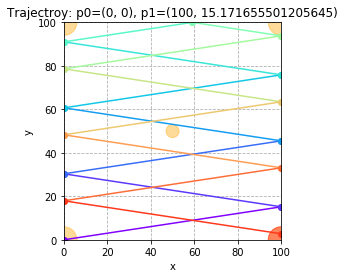

len(images) = 14


In [81]:
p0 = (0,0)
p1 = (100, 100/6.59123851)
s1 = getSide(p1)

epsilon1 = 6
epsilon2 = 3

ptList = [p0, p1]
global fallPocket
fallPocket = (999, 999)

billiard(p0, p1, ptList)
# print("ptList =", ptList)

draw(ptList, makeVideo=False)


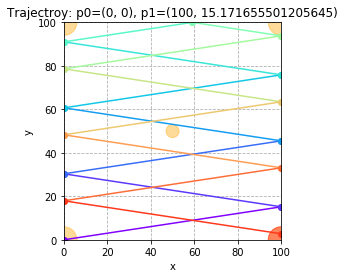

len(images) = 14
Video Done!


In [82]:
draw(ptList, makeVideo=True)

# You could try two things:

## 1. make epsilon2 = epslon1, see if the probability raio (prob of corners / prob of center) is fixed
## 2. make the prob ratio fixed (=1) and see ratio of epsilon2/epsilon1

## Try 1

In [83]:
def conjecture(p0, p1, drawImg=False, drawWithVideo=False):
    ptList = [p0, p1]
    global fallPocket
    fallPocket = (999, 999)

    billiard(p0, p1, ptList)
    if drawImg:
        draw(ptList, makeVideo=drawWithVideo)
    return ptList

In [84]:
math.radians(180)

3.141592653589793

In [85]:
import math
p1Samples = []


step = 3
for angle in range(1, 45, step): #1~45 degree
    theta = math.radians(angle)
    tan = math.tan(theta)
    p1Samples.append((sideLen, sideLen*tan))

for angle in range(45, 90, step): #45~90 degree
    theta = math.radians(angle)
    tan = math.tan(theta)
    p1Samples.append((sideLen/tan, sideLen))


    
print("len(p1Samples) = ", len(p1Samples))

len(p1Samples) =  30


p0, p1 = (0, 0) (100, 1.7455064928217585)
corner... pt = (100, 0)


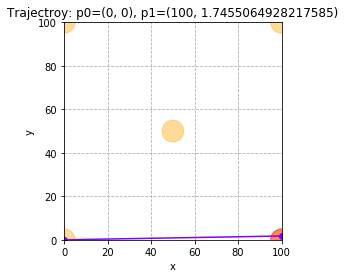

len(images) = 1
p0, p1 = (0, 0) (100, 6.992681194351041)
Fall into CENTER pocket:  (50.0, 50.0)


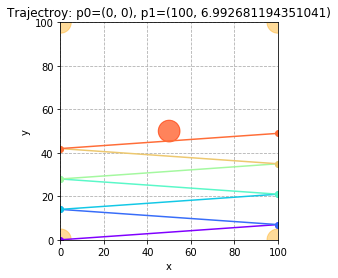

len(images) = 7
p0, p1 = (0, 0) (100, 12.27845609029046)
** pt1, pt2, pt = (100, 85.9491926320332) (0, 98.22764872232366) (0, 100)
Fall into pocket:  (0, 100)


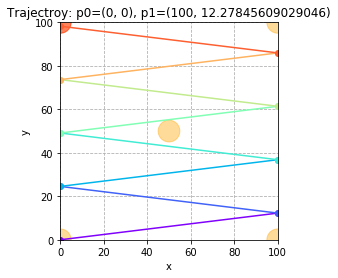

len(images) = 8
p0, p1 = (0, 0) (100, 17.632698070846498)
Fall into CENTER pocket:  (50.0, 50.0)


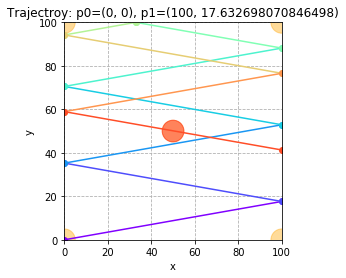

len(images) = 10
p0, p1 = (0, 0) (100, 23.086819112556313)
Fall into CENTER pocket:  (50.0, 50.0)


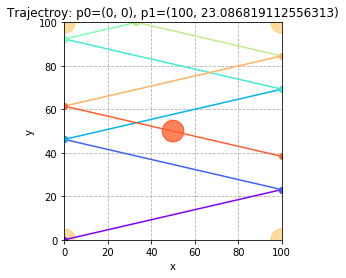

len(images) = 8
p0, p1 = (0, 0) (100, 28.674538575880792)
** pt1, pt2, pt = (0, 27.952768544715198) (97.48288876818155, 0) (100, 0)
Fall into pocket:  (100, 0)


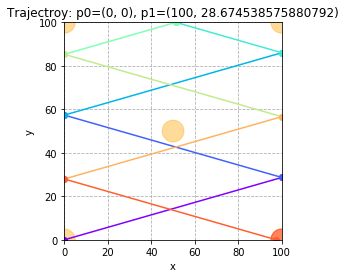

len(images) = 8
p0, p1 = (0, 0) (100, 34.43276132896653)
Fall into CENTER pocket:  (50.0, 50.0)


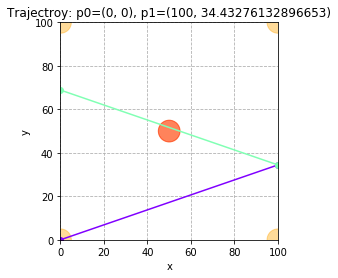

len(images) = 2
p0, p1 = (0, 0) (100, 40.40262258351568)
** pt1, pt2, pt = (0, 38.38950966593728) (95.01737068325919, 0) (100, 0)
Fall into pocket:  (100, 0)


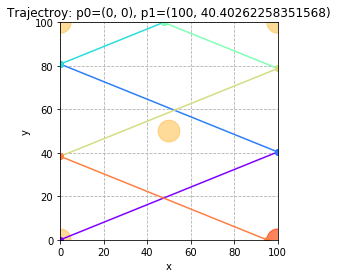

len(images) = 6
p0, p1 = (0, 0) (100, 46.63076581549986)
Fall into CENTER pocket:  (50.0, 50.0)


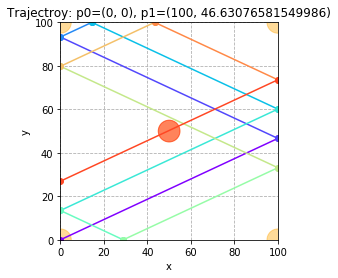

len(images) = 11
p0, p1 = (0, 0) (100, 53.17094316614788)
Fall into CENTER pocket:  (50.0, 50.0)


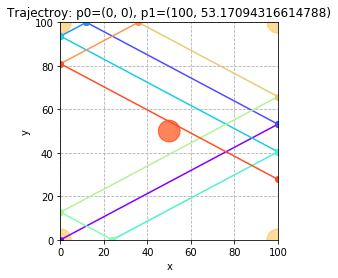

len(images) = 10
p0, p1 = (0, 0) (100, 60.08606190275603)
Fall into CENTER pocket:  (50.0, 50.0)


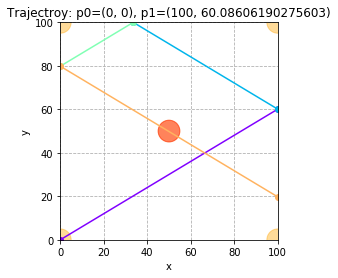

len(images) = 4
p0, p1 = (0, 0) (100, 67.45085168424268)
** pt1, pt2, pt = (0, 65.09829663151464) (96.51219370254799, 0) (100, 0)
Fall into pocket:  (100, 0)


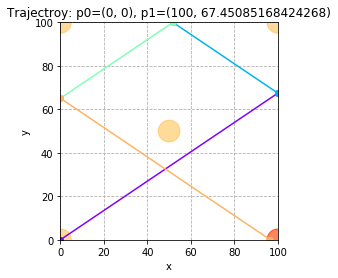

len(images) = 4
p0, p1 = (0, 0) (100, 75.35540501027941)
** pt1, pt2, pt = (100, 26.066215030838208) (1.8865535138769047, 100) (0, 100)
Fall into pocket:  (0, 100)


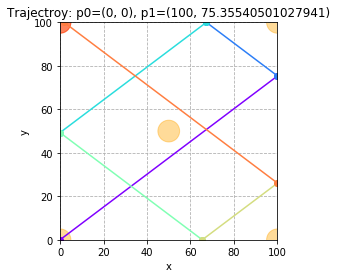

len(images) = 6
p0, p1 = (0, 0) (100, 83.90996311772798)
** pt1, pt2, pt = (100, 19.549815588640026) (4.123203702895054, 100) (0, 100)
Fall into pocket:  (0, 100)


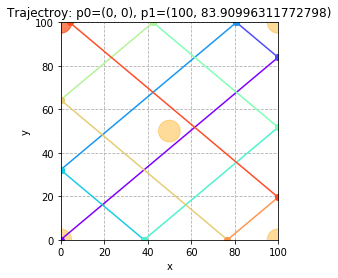

len(images) = 10
p0, p1 = (0, 0) (100, 93.25150861376616)
center return...


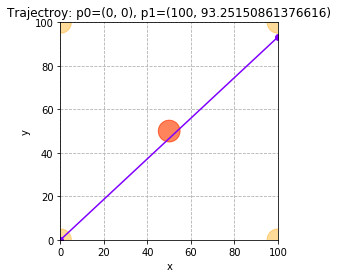

len(images) = 1
p0, p1 = (0, 0) (100.00000000000001, 100)
center return...


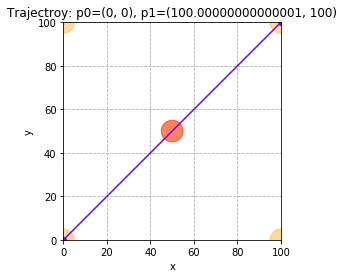

len(images) = 1
p0, p1 = (0, 0) (90.040404429784, 100)
center return...


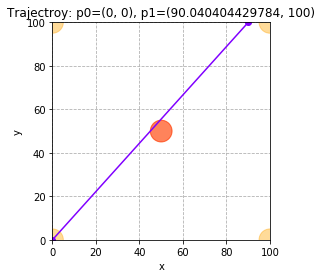

len(images) = 1
p0, p1 = (0, 0) (80.97840331950074, 100)
** pt1, pt2, pt = (0, 93.95886261402046) (4.892016597503655, 100) (0, 100)
Fall into pocket:  (0, 100)


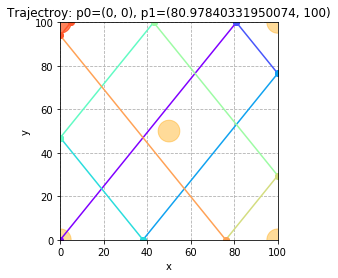

len(images) = 9
p0, p1 = (0, 0) (72.65425280053611, 100)
Fall into CENTER pocket:  (50.0, 50.0)


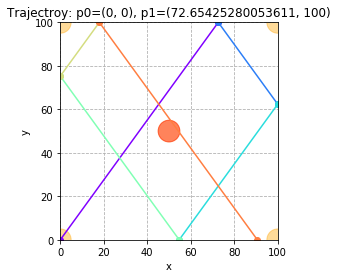

len(images) = 6
p0, p1 = (0, 0) (64.94075931975105, 100)
** pt1, pt2, pt = (5.177722040746829, 100) (0, 92.02700723708341) (0, 100)
Fall into pocket:  (0, 100)


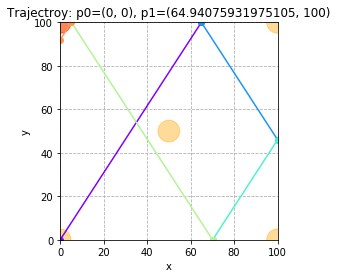

len(images) = 5
p0, p1 = (0, 0) (57.735026918962596, 100)
Fall into CENTER pocket:  (50.0, 50.0)


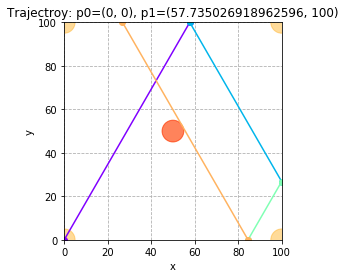

len(images) = 4
p0, p1 = (0, 0) (50.95254494944289, 100)
** pt1, pt2, pt = (50.95254494944289, 100) (100, 3.738949449484977) (100, 0)
Fall into pocket:  (100, 0)


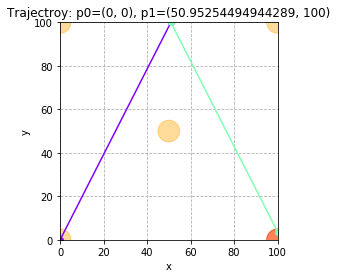

len(images) = 2
p0, p1 = (0, 0) (44.52286853085361, 100)
Fall into CENTER pocket:  (50.0, 50.0)


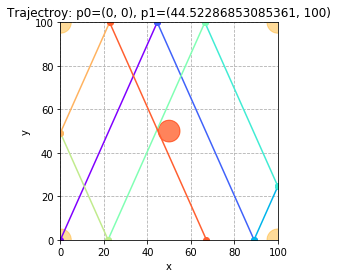

len(images) = 8
p0, p1 = (0, 0) (38.38640350354159, 100)
Fall into CENTER pocket:  (50.0, 50.0)


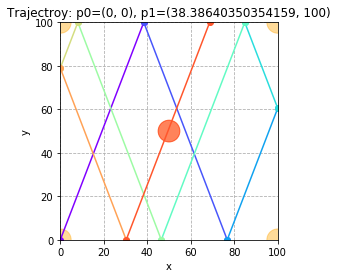

len(images) = 9
p0, p1 = (0, 0) (32.491969623290636, 100)
Fall into CENTER pocket:  (50.0, 50.0)


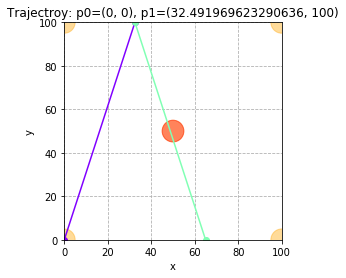

len(images) = 2
p0, p1 = (0, 0) (26.79491924311227, 100)
Fall into CENTER pocket:  (50.0, 50.0)


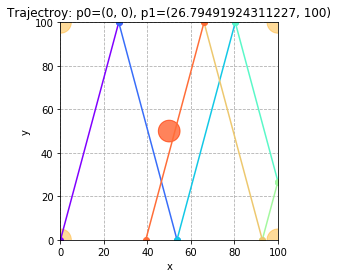

len(images) = 7
p0, p1 = (0, 0) (21.255656167002225, 100)
Fall into CENTER pocket:  (50.0, 50.0)


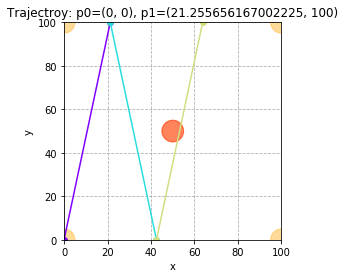

len(images) = 3
p0, p1 = (0, 0) (15.838444032453634, 100)
** pt1, pt2, pt = (79.19222016226816, 100) (95.0306641947218, 0) (100, 0)
Fall into pocket:  (100, 0)


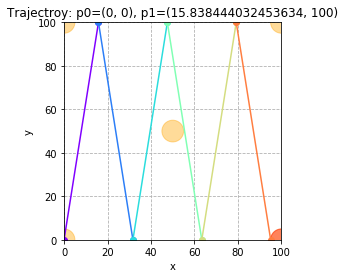

len(images) = 6
p0, p1 = (0, 0) (10.510423526567644, 100)
Fall into CENTER pocket:  (50.0, 50.0)


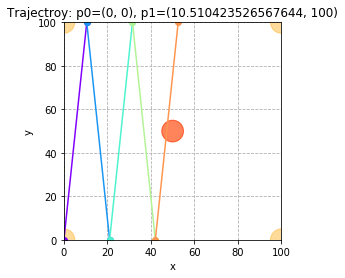

len(images) = 5
p0, p1 = (0, 0) (5.2407779283041345, 100)
Fall into CENTER pocket:  (50.0, 50.0)


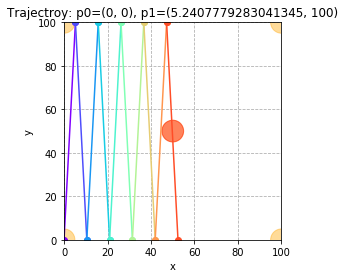

len(images) = 10


In [86]:
epsilon2 = 5
epsilon1 = epsilon2
p0 = (0,0)
for p1 in p1Samples:
    conjecture(p0, p1, drawImg=True, drawWithVideo=False)
    

p0, p1 = (0, 0) (100, 17.34234)
corner... pt = (100, 0)


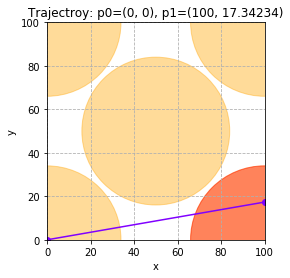

len(images) = 1
p0, p1 = (0, 0) (71.34234, 100)
center return...


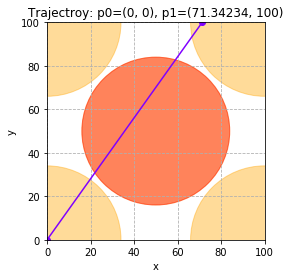

len(images) = 1


[(0, 0), (71.34234, 100)]

In [87]:
# for 6.Billiard-...

epsilon2 = 34
epsilon1 = epsilon2
p0 = (0,0)

conjecture(p0, (100, 17.34234), drawImg=True, drawWithVideo=False)
conjecture(p0, (71.34234, 100), drawImg=True, drawWithVideo=False)


p0, p1 = (0, 0) (100, 17.34234)
Fall into CENTER pocket:  (50.0, 50.0)


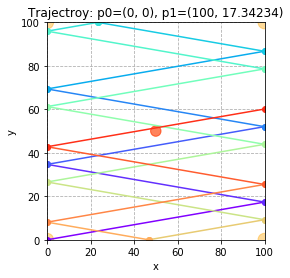

len(images) = 17
p0, p1 = (0, 0) (71.34234, 100)
Fall into CENTER pocket:  (50.0, 50.0)


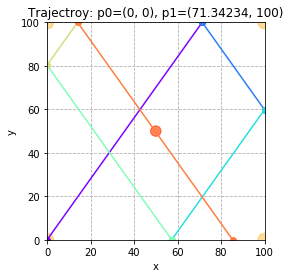

len(images) = 6


[(0, 0),
 (71.34234, 100),
 (100, 59.83078211339857),
 (57.31532000000001, 0),
 (0, 80.33843577320285),
 (14.027019999999997, 100),
 (85.36936, 0)]

In [88]:
# for 6.Billiard-...

epsilon1 = 3

epsilon2 = epsilon1*0.8

p0 = (0,0)

conjecture(p0, (100, 17.34234), drawImg=True, drawWithVideo=False)
conjecture(p0, (71.34234, 100), drawImg=True, drawWithVideo=False)


## Try 2